# Tuning One Parameter

To start trying to find the best possible model for classifying these images, we would like to see how different parameters affect our model individually.

## Table of Contents
1. [Baseline Data and Baseline Model](#basebase) <br>
    1. [Baseline Data](#basedata) <br>
    2. [Class Distribution](#class) <br>
    3. [Baseline Model](#basemodel) <br>
    4. [Tuning Epochs](#epochs) <br>
        1. [50 Epochs](#50epochs) <br>
        2. [75 Epochs](#75epochs) <br>
        3. [100 Epochs](#100epochs) <br>
    5. [Tuning Early Stopping](#early) <br>
        1. [Patience 5](#5patience) <br>
        2. [Patience 10](#10patience) <br>
        3. [Patience 15](#15patience) <br>
2. [Baseline Data and Unique Model](#baseunique) <br>
    1. [Tuning Number of Filters](#filters) <br>
        1. [Double (64 and 128)](#doublefilters) <br>
        2. [Quad (128 and 256)](#quadfilters) <br>
        3. [Oct (256 and 512)](#octfilters) <br>
    2. [Tuning Number of Layers](#layers) <br>
        1. [Increasing Each Dimension By 1](#dimplusone) <br>
        2. [Adding a 5x5 Layer](#5by5) <br>
        3. [Adding a 6x6 Layer, Then a 5x5 Layer](#6by6) <br>
    3. [Tuning Dropout](#dropout) <br>
        1. [Before Flatten Layer](#flatten) <br>
        2. [Before Activation Layer](#activation) <br>
3. [Unique Data and Baseline Model](#uniquebase) <br>
    1. [Transforming Images](#transforming) <br>
        1. [Shift](#shift) <br>
        2. [Shear](#shear) <br>
        3. [Zoom on Training Set Only](#trainzoom) <br>
        4. [Zoom on All Sets](#allzoom) <br>
        5. [All](#all) <br>
    2. [Resizing Images](#resize) <br>
        1. [128x128](#128) <br>
        2. [256x256](#256) <br>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
import metric_functions as mf
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


# Baseline Data and Baseline Model <a id='basebase'></a>

## Baseline Data <a id='basedata'></a>

For our baseline data, we grab our images from our folders, changing nothing other than putting them in the same scale. We split our data into training and validation sets to avoid overfitting.

In [10]:
train_folder = os.path.join('train')
train_pneum = os.path.join(train_folder, 'PNEUMONIA')
train_norm = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join('test')
test_pneum = os.path.join(test_folder, 'PNEUMONIA')
test_norm = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join('val')
val_pneum = os.path.join(val_folder, 'PNEUMONIA')
val_norm = os.path.join(val_folder, 'NORMAL')

In [11]:
print('There are', len(os.listdir(train_pneum)), 'pneumonia images in the train set')
print('There are', len(os.listdir(train_norm)), 'normal images in the train set')
print('There are', len(os.listdir(test_pneum)), 'pneumonia images in the test set')
print('There are', len(os.listdir(test_norm)), 'normal images in the test set')
print('There are', len(os.listdir(val_pneum)), 'pneumonia images in the val set')
print('There are', len(os.listdir(val_norm)), 'normal images in the val set')

There are 3108 pneumonia images in the train set
There are 1080 normal images in the train set
There are 390 pneumonia images in the test set
There are 234 normal images in the test set
There are 777 pneumonia images in the val set
There are 271 normal images in the val set


In [12]:
train_generator_base = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(64, 64), batch_size = 4188, color_mode = 'grayscale')
test_generator_base = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), batch_size = 624, color_mode = 'grayscale')
val_generator_base = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), batch_size = 1048, color_mode = 'grayscale')

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [13]:
train_images_base, train_labels_base = next(train_generator_base)
test_images_base, test_labels_base = next(test_generator_base)
val_images_base, val_labels_base = next(val_generator_base)

In [14]:
class_labels = list(train_generator_base.class_indices.keys())
train_generator_base.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [15]:
train_labels_base

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Our label arrays have 2 columns, one for True and one for False. We only need one of these as having two is redundant.

We see that the second index is for pneumonia. This means if there is a 0 in this column the picture is clasified as normal, and 1 if it's classified as pneumonia. Let's keep this second column as our labels.

In [16]:
print ("train_images shape: " + str(train_images_base.shape))
print ("train_labels shape: " + str(train_labels_base.shape))
print ("test_images shape: " + str(test_images_base.shape))
print ("test_labels shape: " + str(test_labels_base.shape))
print ("val_images shape: " + str(val_images_base.shape))
print ("val_labels shape: " + str(val_labels_base.shape))

train_images shape: (4186, 64, 64, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 64, 64, 1)
val_labels shape: (1046, 2)


In [17]:
train_y_base = np.reshape(train_labels_base[:,1], (4186,1))
test_y_base = np.reshape(test_labels_base[:,1], (624,1))
val_y_base = np.reshape(val_labels_base[:,1], (1046,1))
train_y_base

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

## Class Distribution <a id='class'></a>

Before we start modeling, we want to check for class imbalance. Our data is split into 3 directories, each holding the images needed for our test, train, and validation sets. We'll add up the number of files in these directories to get the count of data points in each class.

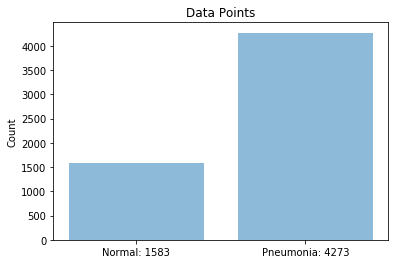

In [2]:
n_count = len(os.listdir('chest_xray/test/NORMAL')) + len(os.listdir('chest_xray/train/NORMAL')) + len(os.listdir('chest_xray/val/NORMAL'))
p_count = len(os.listdir('chest_xray/test/PNEUMONIA')) + len(os.listdir('chest_xray/train/PNEUMONIA')) + len(os.listdir('chest_xray/val/PNEUMONIA'))

objects = (f'Normal: {n_count}', f'Pneumonia: {p_count}')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [n_count,p_count], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Data Points')

plt.show()

We can see we have a 27:73 split. This isn't a huge imbalance, but definitely something to keep in mind when evaluating our models, as our null accuracy is 73%. This is the accuracy we could achieve by always predicting the most frequent class.

## Baseline Model <a id='basemodel'></a>

In [10]:
model_base = models.Sequential()
model_base.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Flatten())
model_base.add(layers.Dense(64, activation='relu'))
model_base.add(layers.Dense(1, activation='sigmoid'))

model_base.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

### Training Baseline Model with Baseline Data

In [11]:
%%time
history_base = model_base.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 4186 samples, validate on 1046 samples
Epoch 1/30
4186/4186 [==============================] - 2s 472us/step - loss: 0.5876 - acc: 0.7303 - val_loss: 0.5712 - val_acc: 0.7419
Epoch 2/30
4186/4186 [==============================] - 1s 201us/step - loss: 0.5581 - acc: 0.7422 - val_loss: 0.5623 - val_acc: 0.7419
Epoch 3/30
4186/4186 [==============================] - 1s 199us/step - loss: 0.5417 - acc: 0.7422 - val_loss: 0.5344 - val_acc: 0.7419
Epoch 4/30
4186/4186 [==============================] - 1s 201us/step - loss: 0.5069 - acc: 0.7422 - val_loss: 0.4891 - val_acc: 0.7973
Epoch 5/30
4186/4186 [==============================] - 1s 200us/step - loss: 0.4609 - acc: 0.7802 - val_loss: 0.3900 - val_acc: 0.8337
Epoch 6/30
4186/4186 [==============================] - 1s 204us/step - loss: 0.4181 - acc: 0.8204 - val_loss: 0.3927 - val_acc: 0.7859
Epoch 7/30
4186/4186 [==============================] - 1s 205us/step - loss: 0.3666 - acc: 0.8385 - val_loss: 0.2854 - val_acc: 0.8776


Accuracy 
 Train: 0.959, Test: 0.728
Loss 
 Train: 0.103, Test: 0.884 



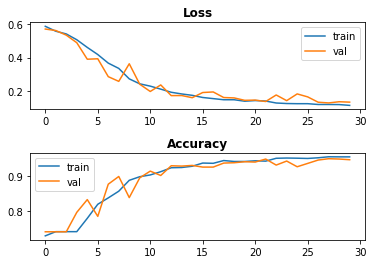



Confusion Matrix, without normalization


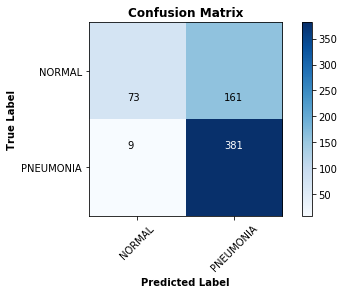



              precision    recall  f1-score   support

      NORMAL       0.89      0.31      0.46       234
   PNEUMONIA       0.70      0.98      0.82       390

    accuracy                           0.73       624
   macro avg       0.80      0.64      0.64       624
weighted avg       0.77      0.73      0.68       624



In [12]:
print(mf.evaluate_test(model_base, history_base, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

Here, we see that accuracy and loss are improving over time for both our training and validation set. This tells us our model has a good fit (not over or underfit). 

Additionally, we can see that although we have a lower precision for the pneumonia class, it has a pretty high recall. We want to make sure our models continue this trend, since we'd prefer to lose some precision over diagnosing someone who has pneumonia as normal.

## Tuning Epochs <a id='epochs'></a>
Baseline: 30

### 50 Epochs <a id='50epochs'></a>

In [13]:
model_epoch_50 = models.Sequential()
model_epoch_50.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_epoch_50.add(layers.MaxPooling2D((2, 2)))

model_epoch_50.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_epoch_50.add(layers.MaxPooling2D((2, 2)))

model_epoch_50.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_50.add(layers.MaxPooling2D((2, 2)))

model_epoch_50.add(layers.Flatten())
model_epoch_50.add(layers.Dense(64, activation='relu'))
model_epoch_50.add(layers.Dense(1, activation='sigmoid'))

model_epoch_50.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [14]:
%%time
history_epoch_50 = model_epoch_50.fit(train_images_base,
                    train_y_base,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 4186 samples, validate on 1046 samples
Epoch 1/50
4186/4186 [==============================] - 1s 237us/step - loss: 0.6186 - acc: 0.7246 - val_loss: 0.5789 - val_acc: 0.7419
Epoch 2/50
4186/4186 [==============================] - 1s 202us/step - loss: 0.5707 - acc: 0.7422 - val_loss: 0.5771 - val_acc: 0.7419
Epoch 3/50
4186/4186 [==============================] - 1s 201us/step - loss: 0.5677 - acc: 0.7422 - val_loss: 0.5707 - val_acc: 0.7419
Epoch 4/50
4186/4186 [==============================] - 1s 205us/step - loss: 0.5618 - acc: 0.7422 - val_loss: 0.5639 - val_acc: 0.7419
Epoch 5/50
4186/4186 [==============================] - 1s 205us/step - loss: 0.5535 - acc: 0.7422 - val_loss: 0.5552 - val_acc: 0.7419
Epoch 6/50
4186/4186 [==============================] - 1s 207us/step - loss: 0.5377 - acc: 0.7422 - val_loss: 0.5296 - val_acc: 0.7419
Epoch 7/50
4186/4186 [==============================] - 1s 204us/step - loss: 0.5034 - acc: 0.7430 - val_loss: 0.4767 - val_acc: 0.7438


Accuracy 
 Train: 0.969, Test: 0.739
Loss 
 Train: 0.085, Test: 0.886 



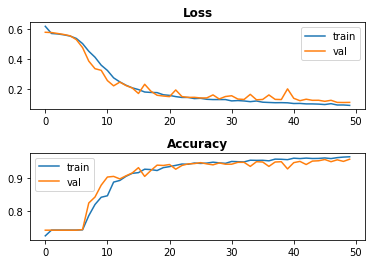



Confusion Matrix, without normalization


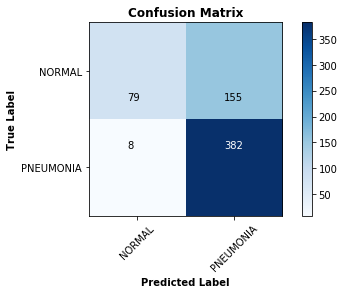



              precision    recall  f1-score   support

      NORMAL       0.91      0.34      0.49       234
   PNEUMONIA       0.71      0.98      0.82       390

    accuracy                           0.74       624
   macro avg       0.81      0.66      0.66       624
weighted avg       0.79      0.74      0.70       624



In [15]:
print(mf.evaluate_test(model_epoch_50, history_epoch_50, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### 75 Epochs <a id='75epochs'></a>

In [16]:
model_epoch_75 = models.Sequential()
model_epoch_75.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_epoch_75.add(layers.MaxPooling2D((2, 2)))

model_epoch_75.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_epoch_75.add(layers.MaxPooling2D((2, 2)))

model_epoch_75.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_75.add(layers.MaxPooling2D((2, 2)))

model_epoch_75.add(layers.Flatten())
model_epoch_75.add(layers.Dense(64, activation='relu'))
model_epoch_75.add(layers.Dense(1, activation='sigmoid'))

model_epoch_75.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [17]:
%%time
history_epoch_75 = model_epoch_75.fit(train_images_base,
                    train_y_base,
                    epochs=75,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 4186 samples, validate on 1046 samples
Epoch 1/75
4186/4186 [==============================] - 1s 232us/step - loss: 0.5960 - acc: 0.7422 - val_loss: 0.5797 - val_acc: 0.7419
Epoch 2/75
4186/4186 [==============================] - 1s 204us/step - loss: 0.5699 - acc: 0.7422 - val_loss: 0.5734 - val_acc: 0.7419
Epoch 3/75
4186/4186 [==============================] - 1s 201us/step - loss: 0.5635 - acc: 0.7422 - val_loss: 0.5647 - val_acc: 0.7419
Epoch 4/75
4186/4186 [==============================] - 1s 202us/step - loss: 0.5528 - acc: 0.7422 - val_loss: 0.5499 - val_acc: 0.7419
Epoch 5/75
4186/4186 [==============================] - 1s 200us/step - loss: 0.5334 - acc: 0.7422 - val_loss: 0.5198 - val_acc: 0.7419
Epoch 6/75
4186/4186 [==============================] - 1s 199us/step - loss: 0.4905 - acc: 0.7470 - val_loss: 0.4498 - val_acc: 0.7725
Epoch 7/75
4186/4186 [==============================] - 1s 199us/step - loss: 0.4471 - acc: 0.7922 - val_loss: 0.4206 - val_acc: 0.7572


Accuracy 
 Train: 0.981, Test: 0.737
Loss 
 Train: 0.055, Test: 1.038 



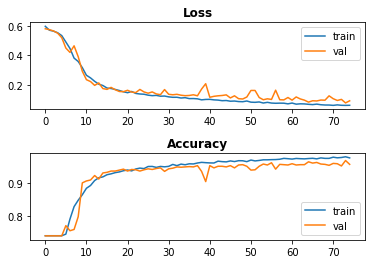



Confusion Matrix, without normalization


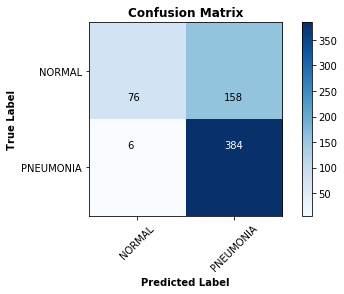



              precision    recall  f1-score   support

      NORMAL       0.93      0.32      0.48       234
   PNEUMONIA       0.71      0.98      0.82       390

    accuracy                           0.74       624
   macro avg       0.82      0.65      0.65       624
weighted avg       0.79      0.74      0.70       624



In [18]:
print(mf.evaluate_test(model_epoch_75, history_epoch_75, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### 100 Epochs <a id='100epochs'></a>

In [19]:
model_epoch_100 = models.Sequential()
model_epoch_100.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_epoch_100.add(layers.MaxPooling2D((2, 2)))

model_epoch_100.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_epoch_100.add(layers.MaxPooling2D((2, 2)))

model_epoch_100.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_100.add(layers.MaxPooling2D((2, 2)))

model_epoch_100.add(layers.Flatten())
model_epoch_100.add(layers.Dense(64, activation='relu'))
model_epoch_100.add(layers.Dense(1, activation='sigmoid'))

model_epoch_100.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [20]:
%%time
history_epoch_100 = model_epoch_100.fit(train_images_base,
                    train_y_base,
                    epochs=100,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 4186 samples, validate on 1046 samples
Epoch 1/100
4186/4186 [==============================] - 1s 234us/step - loss: 0.5898 - acc: 0.7315 - val_loss: 0.5791 - val_acc: 0.7419
Epoch 2/100
4186/4186 [==============================] - 1s 207us/step - loss: 0.5683 - acc: 0.7422 - val_loss: 0.5733 - val_acc: 0.7419
Epoch 3/100
4186/4186 [==============================] - 1s 204us/step - loss: 0.5626 - acc: 0.7422 - val_loss: 0.5642 - val_acc: 0.7419
Epoch 4/100
4186/4186 [==============================] - 1s 195us/step - loss: 0.5513 - acc: 0.7422 - val_loss: 0.5516 - val_acc: 0.7419
Epoch 5/100
4186/4186 [==============================] - 1s 197us/step - loss: 0.5325 - acc: 0.7422 - val_loss: 0.5210 - val_acc: 0.7419
Epoch 6/100
4186/4186 [==============================] - 1s 201us/step - loss: 0.4946 - acc: 0.7489 - val_loss: 0.4666 - val_acc: 0.7428
Epoch 7/100
4186/4186 [==============================] - 1s 198us/step - loss: 0.4598 - acc: 0.7843 - val_loss: 0.4538 - val_acc: 

4186/4186 [==============================] - 1s 201us/step - loss: 0.0838 - acc: 0.9711 - val_loss: 0.1021 - val_acc: 0.9589
Epoch 61/100
4186/4186 [==============================] - 1s 196us/step - loss: 0.0822 - acc: 0.9718 - val_loss: 0.1036 - val_acc: 0.9570
Epoch 62/100
4186/4186 [==============================] - 1s 198us/step - loss: 0.0817 - acc: 0.9711 - val_loss: 0.1030 - val_acc: 0.9589
Epoch 63/100
4186/4186 [==============================] - 1s 197us/step - loss: 0.0806 - acc: 0.9711 - val_loss: 0.1183 - val_acc: 0.9579
Epoch 64/100
4186/4186 [==============================] - 1s 194us/step - loss: 0.0803 - acc: 0.9704 - val_loss: 0.1010 - val_acc: 0.9579
Epoch 65/100
4186/4186 [==============================] - 1s 194us/step - loss: 0.0761 - acc: 0.9740 - val_loss: 0.1119 - val_acc: 0.9579
Epoch 66/100
4186/4186 [==============================] - 1s 196us/step - loss: 0.0755 - acc: 0.9730 - val_loss: 0.0989 - val_acc: 0.9618
Epoch 67/100
4186/4186 [=======================

Accuracy 
 Train: 0.984, Test: 0.750
Loss 
 Train: 0.046, Test: 0.949 



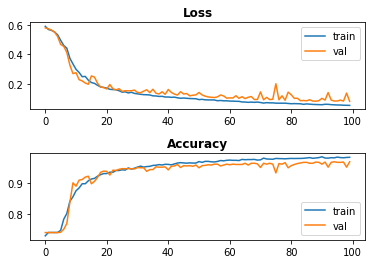



Confusion Matrix, without normalization


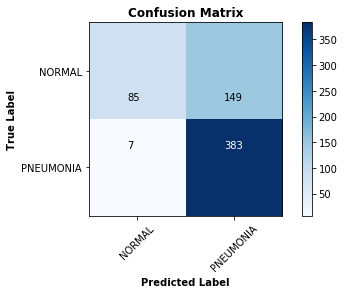



              precision    recall  f1-score   support

      NORMAL       0.92      0.36      0.52       234
   PNEUMONIA       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.68       624
weighted avg       0.80      0.75      0.71       624



In [21]:
print(mf.evaluate_test(model_epoch_100, history_epoch_100, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

We see here that accuracy gets slightly better with more epochs, but most other metrics hover around the same values. The next thing we will tune will allow the model to decide for itself when it’s time to stop.

## Early Stopping <a id='early'></a>

### Patience 5 <a id='5patience'></a>

In [22]:
model_early_5 = models.Sequential()
model_early_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_early_5.add(layers.MaxPooling2D((2, 2)))

model_early_5.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_early_5.add(layers.MaxPooling2D((2, 2)))

model_early_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_early_5.add(layers.MaxPooling2D((2, 2)))

model_early_5.add(layers.Flatten())
model_early_5.add(layers.Dense(64, activation='relu'))
model_early_5.add(layers.Dense(1, activation='sigmoid'))

model_early_5.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [23]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_early_5 = model_early_5.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                    callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 226us/step - loss: 0.5965 - acc: 0.7346 - val_loss: 0.5785 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 194us/step - loss: 0.5696 - acc: 0.7422 - val_loss: 0.5732 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5640 - acc: 0.7422 - val_loss: 0.5659 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5560 - acc: 0.7422 - val_loss: 0.5558 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 205us/step - loss: 0.5414 - acc: 0.7422 - val_loss: 0.5377 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.5115 - acc: 0.7427 - val_loss: 0.5054 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.4661 - acc: 0.7697 - val_loss: 0.4017 - val_acc: 

Accuracy 
 Train: 0.968, Test: 0.726
Loss 
 Train: 0.084, Test: 0.960 



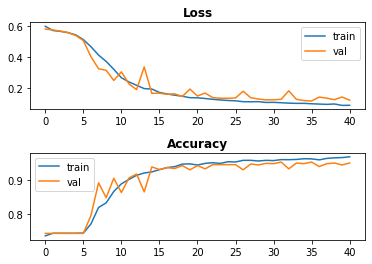



Confusion Matrix, without normalization


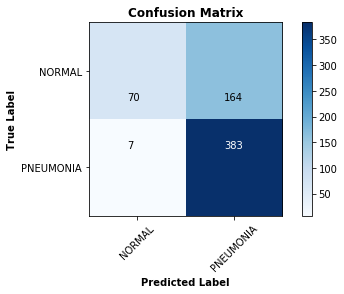



              precision    recall  f1-score   support

      NORMAL       0.91      0.30      0.45       234
   PNEUMONIA       0.70      0.98      0.82       390

    accuracy                           0.73       624
   macro avg       0.80      0.64      0.63       624
weighted avg       0.78      0.73      0.68       624



In [24]:
print(mf.evaluate_test(model_early_5, history_early_5, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Patience 10 <a id='10patience'></a>

In [25]:
model_early_10 = models.Sequential()
model_early_10.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_early_10.add(layers.MaxPooling2D((2, 2)))

model_early_10.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_early_10.add(layers.MaxPooling2D((2, 2)))

model_early_10.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_early_10.add(layers.MaxPooling2D((2, 2)))

model_early_10.add(layers.Flatten())
model_early_10.add(layers.Dense(64, activation='relu'))
model_early_10.add(layers.Dense(1, activation='sigmoid'))

model_early_10.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [26]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 10)]
history_early_10 = model_early_10.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                    callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 231us/step - loss: 0.5972 - acc: 0.7279 - val_loss: 0.5782 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 204us/step - loss: 0.5674 - acc: 0.7422 - val_loss: 0.5772 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 205us/step - loss: 0.5581 - acc: 0.7422 - val_loss: 0.5623 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.5447 - acc: 0.7422 - val_loss: 0.5398 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5189 - acc: 0.7427 - val_loss: 0.4999 - val_acc: 0.7486
Epoch 6/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.4714 - acc: 0.7664 - val_loss: 0.4245 - val_acc: 0.7610
Epoch 7/200
4186/4186 [==============================] - 1s 202us/step - loss: 0.4446 - acc: 0.8051 - val_loss: 0.3752 - val_acc: 

4186/4186 [==============================] - 1s 198us/step - loss: 0.0755 - acc: 0.9718 - val_loss: 0.1395 - val_acc: 0.9512
Epoch 61/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.0739 - acc: 0.9749 - val_loss: 0.1025 - val_acc: 0.9598
Epoch 62/200
4186/4186 [==============================] - 1s 208us/step - loss: 0.0752 - acc: 0.9718 - val_loss: 0.0966 - val_acc: 0.9618
Epoch 63/200
4186/4186 [==============================] - 1s 203us/step - loss: 0.0720 - acc: 0.9728 - val_loss: 0.1201 - val_acc: 0.9512
Epoch 64/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.0748 - acc: 0.9735 - val_loss: 0.1009 - val_acc: 0.9589
Epoch 65/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.0703 - acc: 0.9747 - val_loss: 0.0915 - val_acc: 0.9627
Epoch 66/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.0688 - acc: 0.9737 - val_loss: 0.1335 - val_acc: 0.9512
Epoch 67/200
4186/4186 [=======================

Accuracy 
 Train: 0.978, Test: 0.724
Loss 
 Train: 0.058, Test: 1.144 



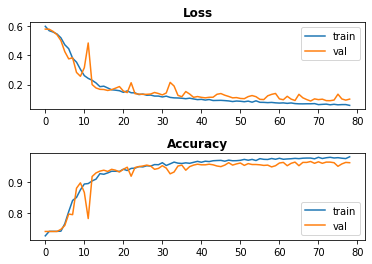



Confusion Matrix, without normalization


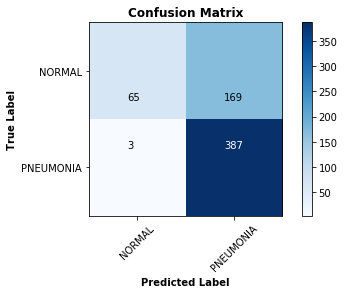



              precision    recall  f1-score   support

      NORMAL       0.96      0.28      0.43       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.83      0.64      0.62       624
weighted avg       0.79      0.72      0.67       624



In [27]:
print(mf.evaluate_test(model_early_10, history_early_10, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Patience 15 <a id='15patience'></a>

In [28]:
model_early_15 = models.Sequential()
model_early_15.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_early_15.add(layers.MaxPooling2D((2, 2)))

model_early_15.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_early_15.add(layers.MaxPooling2D((2, 2)))

model_early_15.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_early_15.add(layers.MaxPooling2D((2, 2)))

model_early_15.add(layers.Flatten())
model_early_15.add(layers.Dense(64, activation='relu'))
model_early_15.add(layers.Dense(1, activation='sigmoid'))

model_early_15.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [29]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 15)]
history_early_15 = model_early_15.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                    callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 229us/step - loss: 0.5952 - acc: 0.7274 - val_loss: 0.5763 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 207us/step - loss: 0.5660 - acc: 0.7422 - val_loss: 0.5698 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 201us/step - loss: 0.5589 - acc: 0.7422 - val_loss: 0.5592 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 203us/step - loss: 0.5456 - acc: 0.7422 - val_loss: 0.5421 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 198us/step - loss: 0.5207 - acc: 0.7422 - val_loss: 0.5231 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 202us/step - loss: 0.4720 - acc: 0.7609 - val_loss: 0.4121 - val_acc: 0.8155
Epoch 7/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.4388 - acc: 0.7969 - val_loss: 0.4784 - val_acc: 

4186/4186 [==============================] - 1s 199us/step - loss: 0.0818 - acc: 0.9709 - val_loss: 0.1057 - val_acc: 0.9541
Epoch 61/200
4186/4186 [==============================] - 1s 198us/step - loss: 0.0814 - acc: 0.9697 - val_loss: 0.1045 - val_acc: 0.9551
Epoch 62/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.0797 - acc: 0.9687 - val_loss: 0.1183 - val_acc: 0.9551
Epoch 63/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.0768 - acc: 0.9718 - val_loss: 0.1135 - val_acc: 0.9560
Epoch 64/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.0765 - acc: 0.9723 - val_loss: 0.1323 - val_acc: 0.9493
Epoch 65/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.0744 - acc: 0.9742 - val_loss: 0.1017 - val_acc: 0.9579
Epoch 66/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.0752 - acc: 0.9723 - val_loss: 0.1085 - val_acc: 0.9570
Epoch 67/200
4186/4186 [=======================

Accuracy 
 Train: 0.990, Test: 0.736
Loss 
 Train: 0.030, Test: 1.248 



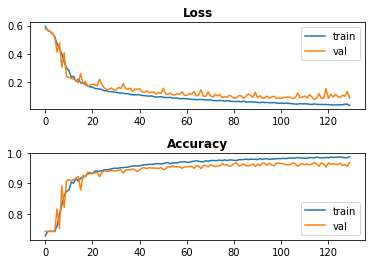



Confusion Matrix, without normalization


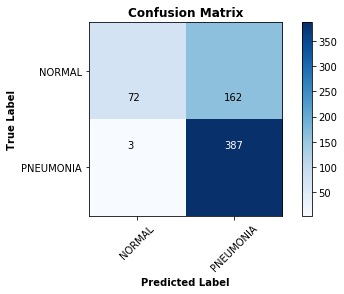



              precision    recall  f1-score   support

      NORMAL       0.96      0.31      0.47       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.74       624
   macro avg       0.83      0.65      0.65       624
weighted avg       0.80      0.74      0.69       624



In [30]:
print(mf.evaluate_test(model_early_15, history_early_15, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

Here we can see a positive trend between patience and model performance. We’ll use early stopping in our more complex models.

# Baseline Data and Unique Model <a id='baseunique'></a>

## Tuning Number of Filters <a id='filters'></a>
Baseline: 32 and 64

### Double (64 and 128) <a id='doublefilters'></a>

In [76]:
model_filter_doub = models.Sequential()
model_filter_doub.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_filter_doub.add(layers.MaxPooling2D((2, 2)))

model_filter_doub.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_filter_doub.add(layers.MaxPooling2D((2, 2)))

model_filter_doub.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_filter_doub.add(layers.MaxPooling2D((2, 2)))

model_filter_doub.add(layers.Flatten())
model_filter_doub.add(layers.Dense(128, activation='relu'))
model_filter_doub.add(layers.Dense(1, activation='sigmoid'))

model_filter_doub.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [77]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_filter_doub = model_filter_doub.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                           callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 2s 398us/step - loss: 0.6012 - acc: 0.7408 - val_loss: 0.5784 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 2s 362us/step - loss: 0.5671 - acc: 0.7422 - val_loss: 0.5701 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 357us/step - loss: 0.5580 - acc: 0.7422 - val_loss: 0.5597 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 2s 365us/step - loss: 0.5457 - acc: 0.7422 - val_loss: 0.5447 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 2s 359us/step - loss: 0.5194 - acc: 0.7441 - val_loss: 0.5113 - val_acc: 0.7620
Epoch 6/200
4186/4186 [==============================] - 1s 358us/step - loss: 0.4776 - acc: 0.7609 - val_loss: 0.4467 - val_acc: 0.8843
Epoch 7/200
4186/4186 [==============================] - 2s 361us/step - loss: 0.4296 - acc: 0.8070 - val_loss: 0.3729 - val_acc: 

Accuracy 
 Train: 0.969, Test: 0.723
Loss 
 Train: 0.082, Test: 1.030 



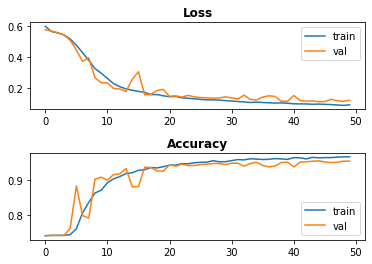



Confusion Matrix, without normalization


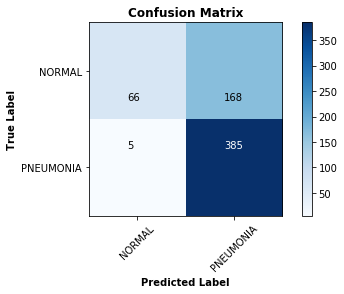



              precision    recall  f1-score   support

      NORMAL       0.93      0.28      0.43       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.81      0.63      0.62       624
weighted avg       0.78      0.72      0.67       624



In [78]:
print(mf.evaluate_test(model_filter_doub, history_filter_doub, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Quad (128 and 256) <a id='quadfilters'></a>

In [79]:
model_filter_quad = models.Sequential()
model_filter_quad.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_filter_quad.add(layers.MaxPooling2D((2, 2)))

model_filter_quad.add(layers.Conv2D(128, (4, 4), activation='relu'))
model_filter_quad.add(layers.MaxPooling2D((2, 2)))

model_filter_quad.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_filter_quad.add(layers.MaxPooling2D((2, 2)))

model_filter_quad.add(layers.Flatten())
model_filter_quad.add(layers.Dense(256, activation='relu'))
model_filter_quad.add(layers.Dense(1, activation='sigmoid'))

model_filter_quad.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [80]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_filter_quad = model_filter_quad.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                           callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 3s 806us/step - loss: 0.5966 - acc: 0.7320 - val_loss: 0.5751 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 3s 771us/step - loss: 0.5654 - acc: 0.7422 - val_loss: 0.5673 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 3s 769us/step - loss: 0.5572 - acc: 0.7422 - val_loss: 0.5565 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 3s 780us/step - loss: 0.5421 - acc: 0.7422 - val_loss: 0.5331 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 3s 775us/step - loss: 0.5127 - acc: 0.7432 - val_loss: 0.4841 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 3s 771us/step - loss: 0.4702 - acc: 0.7781 - val_loss: 0.4159 - val_acc: 0.7667
Epoch 7/200
4186/4186 [==============================] - 3s 775us/step - loss: 0.4360 - acc: 0.7989 - val_loss: 0.3658 - val_acc: 

Accuracy 
 Train: 0.974, Test: 0.726
Loss 
 Train: 0.074, Test: 1.018 



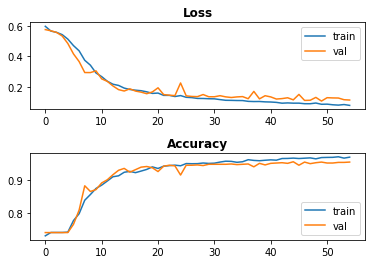



Confusion Matrix, without normalization


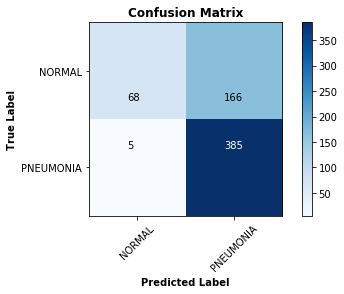



              precision    recall  f1-score   support

      NORMAL       0.93      0.29      0.44       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.63       624
weighted avg       0.79      0.73      0.68       624



In [81]:
print(mf.evaluate_test(model_filter_quad, history_filter_quad, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Oct (256 and 512) <a id='octfilters'></a>

In [82]:
model_filter_oct = models.Sequential()
model_filter_oct.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_filter_oct.add(layers.MaxPooling2D((2, 2)))

model_filter_oct.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_filter_oct.add(layers.MaxPooling2D((2, 2)))

model_filter_oct.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_filter_oct.add(layers.MaxPooling2D((2, 2)))

model_filter_oct.add(layers.Flatten())
model_filter_oct.add(layers.Dense(512, activation='relu'))
model_filter_oct.add(layers.Dense(1, activation='sigmoid'))

model_filter_oct.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [83]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_filter_oct = model_filter_oct.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                         callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 9s 2ms/step - loss: 0.5939 - acc: 0.7365 - val_loss: 0.5772 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.5673 - acc: 0.7422 - val_loss: 0.5705 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.5598 - acc: 0.7422 - val_loss: 0.5616 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.5471 - acc: 0.7422 - val_loss: 0.5467 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.5243 - acc: 0.7422 - val_loss: 0.5144 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.4801 - acc: 0.7587 - val_loss: 0.5739 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 8s 2ms/step - loss: 0.4389 - acc: 0.8015 - val_loss: 0.3806 - val_acc: 0.7906
Epoch 8

Accuracy 
 Train: 0.965, Test: 0.724
Loss 
 Train: 0.093, Test: 0.941 



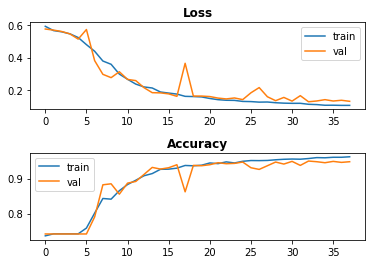



Confusion Matrix, without normalization


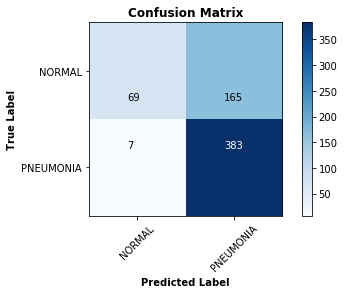



              precision    recall  f1-score   support

      NORMAL       0.91      0.29      0.45       234
   PNEUMONIA       0.70      0.98      0.82       390

    accuracy                           0.72       624
   macro avg       0.80      0.64      0.63       624
weighted avg       0.78      0.72      0.68       624



In [84]:
print(mf.evaluate_test(model_filter_oct, history_filter_oct, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

There doesn't appear to be a negative or positive effect on our metrics when adding more or less filters. They all hover around the same values.

## Tuning Number of Layers  <a id=‘layers’></a>
Baseline: 3x3 input, 4x4 hidden, 3x3 hidden

### Increasing Each Dimension By 1 <a id='dimplusone'></a>

In [85]:
model_layer_plus = models.Sequential()
model_layer_plus.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(64, 64, 1)))
model_layer_plus.add(layers.MaxPooling2D((2, 2)))

model_layer_plus.add(layers.Conv2D(32, (5, 5), activation='relu'))
model_layer_plus.add(layers.MaxPooling2D((2, 2)))

model_layer_plus.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_layer_plus.add(layers.MaxPooling2D((2, 2)))

model_layer_plus.add(layers.Flatten())
model_layer_plus.add(layers.Dense(64, activation='relu'))
model_layer_plus.add(layers.Dense(1, activation='sigmoid'))

model_layer_plus.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [86]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_layer_plus = model_layer_plus.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                         callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 235us/step - loss: 0.5904 - acc: 0.7267 - val_loss: 0.5650 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 206us/step - loss: 0.5490 - acc: 0.7422 - val_loss: 0.5457 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 205us/step - loss: 0.5235 - acc: 0.7422 - val_loss: 0.5488 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 206us/step - loss: 0.4786 - acc: 0.7680 - val_loss: 0.5501 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 206us/step - loss: 0.4208 - acc: 0.8165 - val_loss: 0.3426 - val_acc: 0.8795
Epoch 6/200
4186/4186 [==============================] - 1s 209us/step - loss: 0.3385 - acc: 0.8548 - val_loss: 0.3090 - val_acc: 0.8862
Epoch 7/200
4186/4186 [==============================] - 1s 206us/step - loss: 0.3030 - acc: 0.8681 - val_loss: 0.3366 - val_acc: 

Accuracy 
 Train: 0.957, Test: 0.723
Loss 
 Train: 0.114, Test: 0.959 



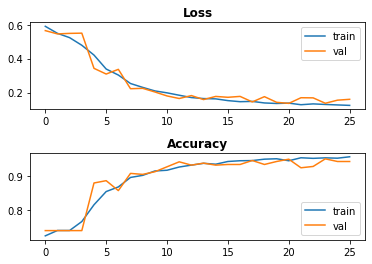



Confusion Matrix, without normalization


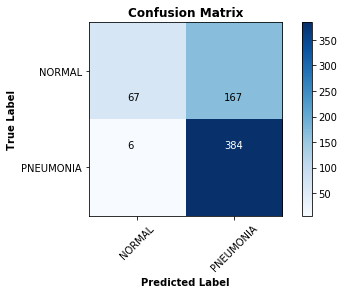



              precision    recall  f1-score   support

      NORMAL       0.92      0.29      0.44       234
   PNEUMONIA       0.70      0.98      0.82       390

    accuracy                           0.72       624
   macro avg       0.81      0.64      0.63       624
weighted avg       0.78      0.72      0.67       624



In [87]:
print(mf.evaluate_test(model_layer_plus, history_layer_plus, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Adding a 5x5 Layer <a id='5by5'></a>

In [88]:
model_layer_five = models.Sequential()
model_layer_five.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Conv2D(32, (5, 5), activation='relu'))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Flatten())
model_layer_five.add(layers.Dense(64, activation='relu'))
model_layer_five.add(layers.Dense(1, activation='sigmoid'))

model_layer_five.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [89]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_layer_five = model_layer_five.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                         callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 251us/step - loss: 0.5963 - acc: 0.7355 - val_loss: 0.5733 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 221us/step - loss: 0.5652 - acc: 0.7422 - val_loss: 0.5716 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 223us/step - loss: 0.5624 - acc: 0.7422 - val_loss: 0.5691 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 221us/step - loss: 0.5592 - acc: 0.7422 - val_loss: 0.5627 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 221us/step - loss: 0.5541 - acc: 0.7422 - val_loss: 0.5560 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 220us/step - loss: 0.5458 - acc: 0.7422 - val_loss: 0.5472 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 1s 223us/step - loss: 0.5312 - acc: 0.7422 - val_loss: 0.5253 - val_acc: 

4186/4186 [==============================] - 1s 221us/step - loss: 0.0867 - acc: 0.9689 - val_loss: 0.0994 - val_acc: 0.9598
Epoch 61/200
4186/4186 [==============================] - 1s 217us/step - loss: 0.0863 - acc: 0.9682 - val_loss: 0.1442 - val_acc: 0.9474
Epoch 62/200
4186/4186 [==============================] - 1s 219us/step - loss: 0.0800 - acc: 0.9711 - val_loss: 0.1009 - val_acc: 0.9608
Epoch 63/200
4186/4186 [==============================] - 1s 218us/step - loss: 0.0815 - acc: 0.9694 - val_loss: 0.0988 - val_acc: 0.9618
Epoch 64/200
4186/4186 [==============================] - 1s 216us/step - loss: 0.0800 - acc: 0.9704 - val_loss: 0.1002 - val_acc: 0.9627
Epoch 65/200
4186/4186 [==============================] - 1s 219us/step - loss: 0.0802 - acc: 0.9697 - val_loss: 0.0939 - val_acc: 0.9637
Epoch 66/200
4186/4186 [==============================] - 1s 217us/step - loss: 0.0786 - acc: 0.9718 - val_loss: 0.0942 - val_acc: 0.9637
Epoch 67/200
4186/4186 [=======================

Accuracy 
 Train: 0.975, Test: 0.745
Loss 
 Train: 0.064, Test: 0.945 



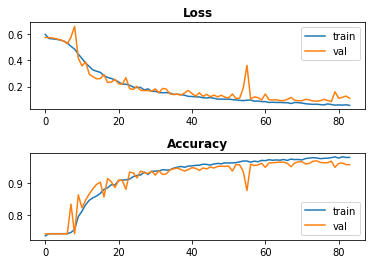



Confusion Matrix, without normalization


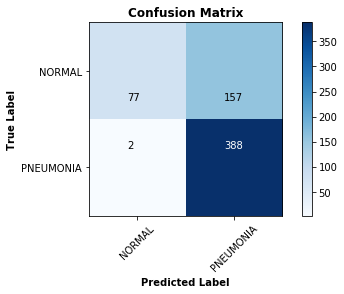



              precision    recall  f1-score   support

      NORMAL       0.97      0.33      0.49       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.70       624



In [90]:
print(mf.evaluate_test(model_layer_five, history_layer_five, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Adding a 6x6 Layer, Then a 5x5 Layer <a id='6by6'></a>
This model doesn't work with the input_shape size we plugged into the layer.

In [ ]:
model_layer_six = models.Sequential()
model_layer_six.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(32, (6, 6), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(128, (4, 4), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Flatten())
model_layer_six.add(layers.Dense(64, activation='relu'))
model_layer_six.add(layers.Dense(1, activation='sigmoid'))

model_layer_six.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

We can clearly see our metrics improving with additional layers. We will include these in more complex models.

## Tuning Dropout <a id='dropout'></a>
Baseline: none

### Before Flatten Layer <a id='flatten'></a>

In [91]:
model_dropout_flatten = models.Sequential()
model_dropout_flatten.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_dropout_flatten.add(layers.MaxPooling2D((2, 2)))

model_dropout_flatten.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_dropout_flatten.add(layers.MaxPooling2D((2, 2)))

model_dropout_flatten.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout_flatten.add(layers.MaxPooling2D((2, 2)))

model_dropout_flatten.add(Dropout(.3))
model_dropout_flatten.add(layers.Flatten())
model_dropout_flatten.add(layers.Dense(64, activation='relu'))
model_dropout_flatten.add(layers.Dense(1, activation='sigmoid'))

model_dropout_flatten.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [92]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_dropout_flatten = model_dropout_flatten.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                                   callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 237us/step - loss: 0.5851 - acc: 0.7422 - val_loss: 0.5811 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 201us/step - loss: 0.5734 - acc: 0.7422 - val_loss: 0.5750 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 203us/step - loss: 0.5663 - acc: 0.7422 - val_loss: 0.5658 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 203us/step - loss: 0.5593 - acc: 0.7422 - val_loss: 0.5540 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 202us/step - loss: 0.5443 - acc: 0.7422 - val_loss: 0.5342 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 201us/step - loss: 0.5293 - acc: 0.7449 - val_loss: 0.5017 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 1s 203us/step - loss: 0.4953 - acc: 0.7587 - val_loss: 0.4434 - val_acc: 

Accuracy 
 Train: 0.952, Test: 0.793
Loss 
 Train: 0.126, Test: 0.550 



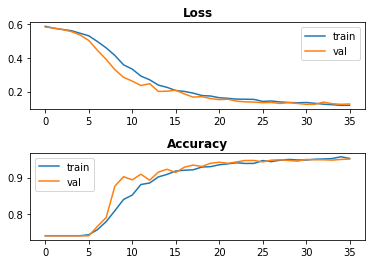



Confusion Matrix, without normalization


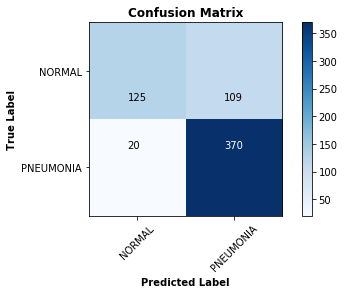



              precision    recall  f1-score   support

      NORMAL       0.86      0.53      0.66       234
   PNEUMONIA       0.77      0.95      0.85       390

    accuracy                           0.79       624
   macro avg       0.82      0.74      0.76       624
weighted avg       0.81      0.79      0.78       624



In [93]:
print(mf.evaluate_test(model_dropout_flatten, history_dropout_flatten, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

### Before Activation Layer <a id='activation'></a>

In [94]:
model_dropout_activation = models.Sequential()
model_dropout_activation.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_dropout_activation.add(layers.MaxPooling2D((2, 2)))

model_dropout_activation.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_dropout_activation.add(layers.MaxPooling2D((2, 2)))

model_dropout_activation.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout_activation.add(layers.MaxPooling2D((2, 2)))

model_dropout_activation.add(layers.Flatten())
model_dropout_activation.add(layers.Dense(64, activation='relu'))
model_dropout_activation.add(Dropout(.3))
model_dropout_activation.add(layers.Dense(1, activation='sigmoid'))

model_dropout_activation.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [95]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_dropout_activation = model_dropout_activation.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                                                         callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 236us/step - loss: 0.5961 - acc: 0.7372 - val_loss: 0.5766 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.5714 - acc: 0.7422 - val_loss: 0.5683 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 202us/step - loss: 0.5612 - acc: 0.7422 - val_loss: 0.5535 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 202us/step - loss: 0.5455 - acc: 0.7422 - val_loss: 0.5365 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.5165 - acc: 0.7463 - val_loss: 0.4858 - val_acc: 0.7543
Epoch 6/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.4717 - acc: 0.7762 - val_loss: 0.5007 - val_acc: 0.7428
Epoch 7/200
4186/4186 [==============================] - 1s 203us/step - loss: 0.4441 - acc: 0.7936 - val_loss: 0.4270 - val_acc: 

Accuracy 
 Train: 0.969, Test: 0.723
Loss 
 Train: 0.084, Test: 1.016 



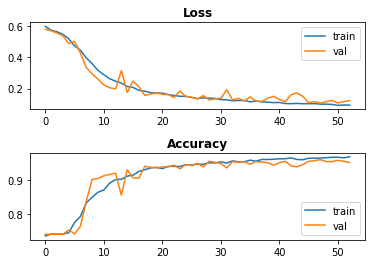



Confusion Matrix, without normalization


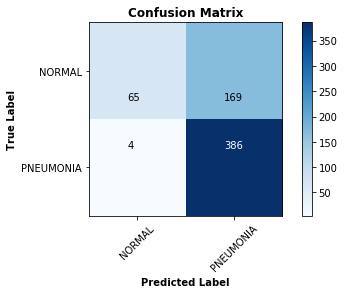



              precision    recall  f1-score   support

      NORMAL       0.94      0.28      0.43       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.82      0.63      0.62       624
weighted avg       0.79      0.72      0.67       624



In [96]:
print(mf.evaluate_test(model_dropout_activation, history_dropout_activation, class_labels, train_images_base, test_images_base, train_y_base, test_y_base))

Adding Dropout before the flatten layer gives us better results.

# Unique Data and Baseline Model <a id='uniquebase'></a>

## Transforming Images <a id='transforming'></a>
Baseline: none

### Shift <a id='shift'></a>

In [97]:
train_generator_shift = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 4188)
test_generator_shift = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_shift = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [98]:
train_images_shift, train_labels_shift = next(train_generator_shift)
test_images_shift, test_labels_shift = next(test_generator_shift)
val_images_shift, val_labels_shift = next(val_generator_shift)
train_y_shift = np.reshape(train_labels_shift[:,1], (4186,1))
test_y_shift = np.reshape(test_labels_shift[:,1], (624,1))
val_y_shift = np.reshape(val_labels_shift[:,1], (1046,1))
print ("train_images shape: " + str(train_images_shift.shape))
print ("train_labels shape: " + str(train_labels_shift.shape))
print ("test_images shape: " + str(test_images_shift.shape))
print ("test_labels shape: " + str(test_labels_shift.shape))
print ("val_images shape: " + str(val_images_shift.shape))
print ("val_labels shape: " + str(val_labels_shift.shape))

train_images shape: (4186, 64, 64, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 64, 64, 1)
val_labels shape: (1046, 2)


In [99]:
model_transform_shift = models.Sequential()
model_transform_shift.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_shift.add(layers.MaxPooling2D((2, 2)))

model_transform_shift.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_shift.add(layers.MaxPooling2D((2, 2)))

model_transform_shift.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_shift.add(layers.MaxPooling2D((2, 2)))

model_transform_shift.add(layers.Flatten())
model_transform_shift.add(layers.Dense(64, activation='relu'))
model_transform_shift.add(layers.Dense(1, activation='sigmoid'))

model_transform_shift.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [100]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_transform_shift = model_transform_shift.fit(train_images_shift,
                    train_y_shift,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_shift, val_y_shift),
                                                   callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 230us/step - loss: 0.6009 - acc: 0.7413 - val_loss: 0.5785 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 195us/step - loss: 0.5701 - acc: 0.7422 - val_loss: 0.5735 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5675 - acc: 0.7422 - val_loss: 0.5718 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 195us/step - loss: 0.5633 - acc: 0.7422 - val_loss: 0.5641 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 194us/step - loss: 0.5582 - acc: 0.7422 - val_loss: 0.5538 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5490 - acc: 0.7422 - val_loss: 0.5413 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5367 - acc: 0.7422 - val_loss: 0.5139 - val_acc: 

Accuracy 
 Train: 0.913, Test: 0.748
Loss 
 Train: 0.209, Test: 0.689 



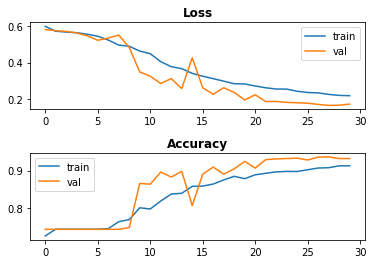



Confusion Matrix, without normalization


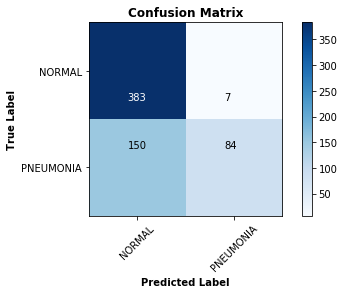



              precision    recall  f1-score   support

      NORMAL       0.72      0.98      0.83       390
   PNEUMONIA       0.92      0.36      0.52       234

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



In [45]:
print(mf.evaluate_test(model_transform_shift, history_transform_shift, class_labels, train_images_shift, test_images_shift, train_y_shift, test_y_shift))

### Shear <a id='shear'></a>
Range = 15 degrees

In [101]:
train_generator_shear = ImageDataGenerator(rescale=1./255,
                                           shear_range=15).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 4188)
test_generator_shear = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_shear = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [102]:
train_images_shear, train_labels_shear = next(train_generator_shear)
test_images_shear, test_labels_shear = next(test_generator_shear)
val_images_shear, val_labels_shear = next(val_generator_shear)
train_y_shear = np.reshape(train_labels_shear[:,1], (4186,1))
test_y_shear = np.reshape(test_labels_shear[:,1], (624,1))
val_y_shear = np.reshape(val_labels_shear[:,1], (1046,1))
print ("train_images shape: " + str(train_images_shear.shape))
print ("train_labels shape: " + str(train_labels_shear.shape))
print ("test_images shape: " + str(test_images_shear.shape))
print ("test_labels shape: " + str(test_labels_shear.shape))
print ("val_images shape: " + str(val_images_shear.shape))
print ("val_labels shape: " + str(val_labels_shear.shape))

train_images shape: (4186, 64, 64, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 64, 64, 1)
val_labels shape: (1046, 2)


In [103]:
model_transform_shear = models.Sequential()
model_transform_shear.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_shear.add(layers.MaxPooling2D((2, 2)))

model_transform_shear.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_shear.add(layers.MaxPooling2D((2, 2)))

model_transform_shear.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_shear.add(layers.MaxPooling2D((2, 2)))

model_transform_shear.add(layers.Flatten())
model_transform_shear.add(layers.Dense(64, activation='relu'))
model_transform_shear.add(layers.Dense(1, activation='sigmoid'))

model_transform_shear.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [104]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_transform_shear = model_transform_shear.fit(train_images_shear,
                    train_y_shear,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_shear, val_y_shear),
                                                   callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 225us/step - loss: 0.5890 - acc: 0.7341 - val_loss: 0.5778 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 194us/step - loss: 0.5622 - acc: 0.7422 - val_loss: 0.5661 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5497 - acc: 0.7422 - val_loss: 0.5456 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 194us/step - loss: 0.5280 - acc: 0.7422 - val_loss: 0.5120 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.4886 - acc: 0.7530 - val_loss: 0.4502 - val_acc: 0.7505
Epoch 6/200
4186/4186 [==============================] - 1s 201us/step - loss: 0.4503 - acc: 0.7929 - val_loss: 0.6893 - val_acc: 0.5583
Epoch 7/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.4165 - acc: 0.8103 - val_loss: 0.3584 - val_acc: 

4186/4186 [==============================] - 1s 195us/step - loss: 0.0792 - acc: 0.9689 - val_loss: 0.1077 - val_acc: 0.9560
Epoch 61/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.0751 - acc: 0.9716 - val_loss: 0.1076 - val_acc: 0.9551
Epoch 62/200
4186/4186 [==============================] - 1s 192us/step - loss: 0.0754 - acc: 0.9720 - val_loss: 0.1097 - val_acc: 0.9522
Epoch 63/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.0725 - acc: 0.9752 - val_loss: 0.1014 - val_acc: 0.9560
Epoch 64/200
4186/4186 [==============================] - 1s 195us/step - loss: 0.0780 - acc: 0.9713 - val_loss: 0.1015 - val_acc: 0.9551
CPU times: user 43.4 s, sys: 8.32 s, total: 51.7 s
Wall time: 53 s


Accuracy 
 Train: 0.976, Test: 0.736
Loss 
 Train: 0.062, Test: 1.002 



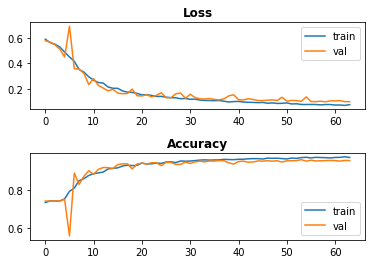



Confusion Matrix, without normalization


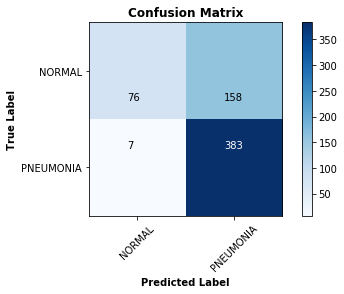



              precision    recall  f1-score   support

      NORMAL       0.92      0.32      0.48       234
   PNEUMONIA       0.71      0.98      0.82       390

    accuracy                           0.74       624
   macro avg       0.81      0.65      0.65       624
weighted avg       0.79      0.74      0.69       624



In [105]:
print(mf.evaluate_test(model_transform_shear, history_transform_shear, class_labels, train_images_shear, test_images_shear, train_y_shear, test_y_shear))

### Zoom on Training Set Only <a id='trainzoom'></a>
Range = 90%

In [106]:
train_generator_zoom_train = ImageDataGenerator(rescale=1./255,
                                           zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 4188)
test_generator_zoom_train = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_zoom_train = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [107]:
train_images_zoom_train, train_labels_zoom_train = next(train_generator_zoom_train)
test_images_zoom_train, test_labels_zoom_train = next(test_generator_zoom_train)
val_images_zoom_train, val_labels_zoom_train = next(val_generator_zoom_train)
train_y_zoom_train = np.reshape(train_labels_zoom_train[:,1], (4186,1))
test_y_zoom_train = np.reshape(test_labels_zoom_train[:,1], (624,1))
val_y_zoom_train = np.reshape(val_labels_zoom_train[:,1], (1046,1))
print ("train_images shape: " + str(train_images_zoom_train.shape))
print ("train_labels shape: " + str(train_labels_zoom_train.shape))
print ("test_images shape: " + str(test_images_zoom_train.shape))
print ("test_labels shape: " + str(test_labels_zoom_train.shape))
print ("val_images shape: " + str(val_images_zoom_train.shape))
print ("val_labels shape: " + str(val_labels_zoom_train.shape))

train_images shape: (4186, 64, 64, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 64, 64, 1)
val_labels shape: (1046, 2)


In [108]:
model_transform_zoom_train = models.Sequential()
model_transform_zoom_train.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_zoom_train.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_train.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_zoom_train.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_train.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_zoom_train.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_train.add(layers.Flatten())
model_transform_zoom_train.add(layers.Dense(64, activation='relu'))
model_transform_zoom_train.add(layers.Dense(1, activation='sigmoid'))

model_transform_zoom_train.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [109]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_transform_zoom_train = model_transform_zoom_train.fit(train_images_zoom_train,
                    train_y_zoom_train,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_zoom_train, val_y_zoom_train),
                                                             callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 229us/step - loss: 0.5946 - acc: 0.7420 - val_loss: 0.5826 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 194us/step - loss: 0.5699 - acc: 0.7422 - val_loss: 0.5780 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5648 - acc: 0.7422 - val_loss: 0.5721 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5587 - acc: 0.7422 - val_loss: 0.5659 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5481 - acc: 0.7422 - val_loss: 0.5528 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 198us/step - loss: 0.5309 - acc: 0.7422 - val_loss: 0.5303 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 1s 198us/step - loss: 0.4914 - acc: 0.7489 - val_loss: 0.4636 - val_acc: 

Accuracy 
 Train: 0.965, Test: 0.848
Loss 
 Train: 0.099, Test: 0.409 



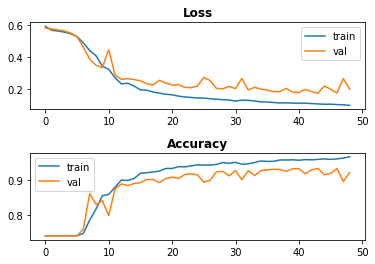



Confusion Matrix, without normalization


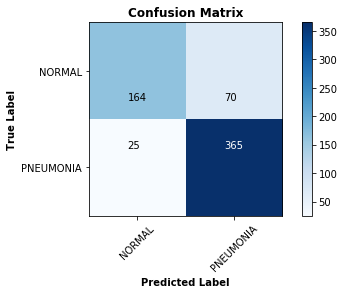



              precision    recall  f1-score   support

      NORMAL       0.87      0.70      0.78       234
   PNEUMONIA       0.84      0.94      0.88       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.84       624



In [110]:
print(mf.evaluate_test(model_transform_zoom_train, history_transform_zoom_train, class_labels, train_images_zoom_train, test_images_zoom_train, train_y_zoom_train, test_y_zoom_train))

### Zoom on All Sets <a id='allzoom'></a>
Range = 90%

In [111]:
train_generator_zoom_all = ImageDataGenerator(rescale=1./255,
                                                zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 4188)
test_generator_zoom_all = ImageDataGenerator(rescale=1./255,
                                               zoom_range=[.9, .9]).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_zoom_all = ImageDataGenerator(rescale=1./255,
                                              zoom_range=[.9, .9]).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [112]:
train_images_zoom_all, train_labels_zoom_all = next(train_generator_zoom_all)
test_images_zoom_all, test_labels_zoom_all = next(test_generator_zoom_all)
val_images_zoom_all, val_labels_zoom_all = next(val_generator_zoom_all)
train_y_zoom_all = np.reshape(train_labels_zoom_all[:,1], (4186,1))
test_y_zoom_all = np.reshape(test_labels_zoom_all[:,1], (624,1))
val_y_zoom_all = np.reshape(val_labels_zoom_all[:,1], (1046,1))
print ("train_images shape: " + str(train_images_zoom_all.shape))
print ("train_labels shape: " + str(train_labels_zoom_all.shape))
print ("test_images shape: " + str(test_images_zoom_all.shape))
print ("test_labels shape: " + str(test_labels_zoom_all.shape))
print ("val_images shape: " + str(val_images_zoom_all.shape))
print ("val_labels shape: " + str(val_labels_zoom_all.shape))

train_images shape: (4186, 64, 64, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 64, 64, 1)
val_labels shape: (1046, 2)


In [113]:
model_transform_zoom_all = models.Sequential()
model_transform_zoom_all.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_zoom_all.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_all.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_zoom_all.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_all.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_zoom_all.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_all.add(layers.Flatten())
model_transform_zoom_all.add(layers.Dense(64, activation='relu'))
model_transform_zoom_all.add(layers.Dense(1, activation='sigmoid'))

model_transform_zoom_all.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [114]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_transform_zoom_all = model_transform_zoom_all.fit(train_images_zoom_all,
                    train_y_zoom_all,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_zoom_all, val_y_zoom_all),
                                                         callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 227us/step - loss: 0.5850 - acc: 0.7396 - val_loss: 0.5696 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5529 - acc: 0.7422 - val_loss: 0.5694 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 198us/step - loss: 0.5372 - acc: 0.7422 - val_loss: 0.5386 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.4994 - acc: 0.7480 - val_loss: 0.4646 - val_acc: 0.7505
Epoch 5/200
4186/4186 [==============================] - 1s 199us/step - loss: 0.4601 - acc: 0.7788 - val_loss: 0.3975 - val_acc: 0.7983
Epoch 6/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.4194 - acc: 0.8079 - val_loss: 0.3694 - val_acc: 0.8891
Epoch 7/200
4186/4186 [==============================] - 1s 198us/step - loss: 0.3588 - acc: 0.8454 - val_loss: 0.3356 - val_acc: 

Accuracy 
 Train: 0.957, Test: 0.724
Loss 
 Train: 0.106, Test: 0.935 



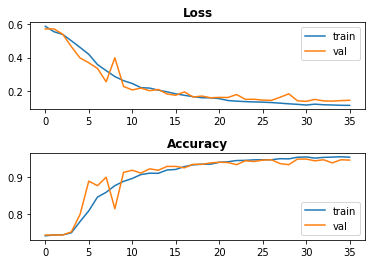



Confusion Matrix, without normalization


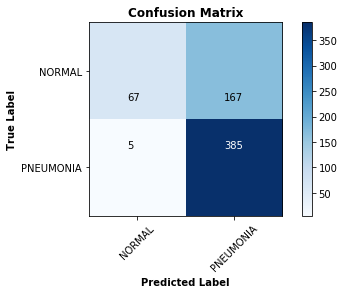



              precision    recall  f1-score   support

      NORMAL       0.93      0.29      0.44       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.81      0.64      0.63       624
weighted avg       0.78      0.72      0.68       624



In [115]:
print(mf.evaluate_test(model_transform_zoom_all, history_transform_zoom_all, class_labels, train_images_zoom_all, test_images_zoom_all, train_y_zoom_all, test_y_zoom_all))

### All <a id='all'></a>
Shift, Shear, and Zoom

In [116]:
train_generator_transforms = ImageDataGenerator(rescale=1./255,
                                                width_shift_range=0.1,
                                                height_shift_range=0.1,
                                                shear_range=15,
                                                zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 4188)
test_generator_transforms = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_transforms = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [117]:
train_images_transforms, train_labels_transforms = next(train_generator_transforms)
test_images_transforms, test_labels_transforms = next(test_generator_transforms)
val_images_transforms, val_labels_transforms = next(val_generator_transforms)
train_y_transforms = np.reshape(train_labels_transforms[:,1], (4186,1))
test_y_transforms = np.reshape(test_labels_transforms[:,1], (624,1))
val_y_transforms = np.reshape(val_labels_transforms[:,1], (1046,1))
print ("train_images shape: " + str(train_images_transforms.shape))
print ("train_labels shape: " + str(train_labels_transforms.shape))
print ("test_images shape: " + str(test_images_transforms.shape))
print ("test_labels shape: " + str(test_labels_transforms.shape))
print ("val_images shape: " + str(val_images_transforms.shape))
print ("val_labels shape: " + str(val_labels_transforms.shape))

train_images shape: (4186, 64, 64, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 64, 64, 1)
val_labels shape: (1046, 2)


In [118]:
model_transform_combined = models.Sequential()
model_transform_combined.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_combined.add(layers.MaxPooling2D((2, 2)))

model_transform_combined.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_combined.add(layers.MaxPooling2D((2, 2)))

model_transform_combined.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_combined.add(layers.MaxPooling2D((2, 2)))

model_transform_combined.add(layers.Flatten())
model_transform_combined.add(layers.Dense(64, activation='relu'))
model_transform_combined.add(layers.Dense(1, activation='sigmoid'))

model_transform_combined.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [119]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_transform_combined = model_transform_combined.fit(train_images_transforms,
                    train_y_transforms,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_transforms, val_y_transforms),
                                                         callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 1s 230us/step - loss: 0.6077 - acc: 0.7353 - val_loss: 0.5784 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5698 - acc: 0.7422 - val_loss: 0.5755 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 1s 196us/step - loss: 0.5671 - acc: 0.7422 - val_loss: 0.5713 - val_acc: 0.7419
Epoch 4/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.5647 - acc: 0.7422 - val_loss: 0.5673 - val_acc: 0.7419
Epoch 5/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5611 - acc: 0.7422 - val_loss: 0.5609 - val_acc: 0.7419
Epoch 6/200
4186/4186 [==============================] - 1s 197us/step - loss: 0.5562 - acc: 0.7422 - val_loss: 0.5548 - val_acc: 0.7419
Epoch 7/200
4186/4186 [==============================] - 1s 200us/step - loss: 0.5490 - acc: 0.7422 - val_loss: 0.5403 - val_acc: 

Accuracy 
 Train: 0.928, Test: 0.849
Loss 
 Train: 0.184, Test: 0.375 



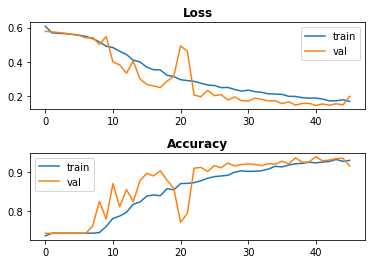



Confusion Matrix, without normalization


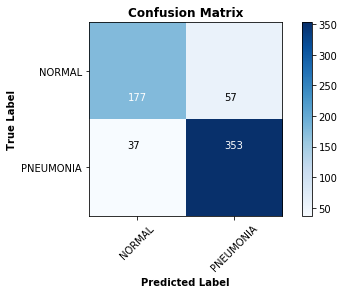



              precision    recall  f1-score   support

      NORMAL       0.83      0.76      0.79       234
   PNEUMONIA       0.86      0.91      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.83      0.84       624
weighted avg       0.85      0.85      0.85       624



In [120]:
print(mf.evaluate_test(model_transform_combined, history_transform_combined, class_labels, train_images_transforms, test_images_transforms, train_y_transforms, test_y_transforms))

Using all transformations on the training set gives us the best results. Although our recall is a bit lower, it is still above 0.90, with high precision and accuracy.

## Resizing Images <a id='resize'></a>
Baseline: 64x64

### 128x128 <a id='128'></a>

In [121]:
train_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 4188)
test_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 624)
val_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [122]:
train_images_128, train_labels_128 = next(train_generator_128)
test_images_128, test_labels_128 = next(test_generator_128)
val_images_128, val_labels_128 = next(val_generator_128)
train_y_128 = np.reshape(train_labels_128[:,1], (4186,1))
test_y_128 = np.reshape(test_labels_128[:,1], (624,1))
val_y_128 = np.reshape(val_labels_128[:,1], (1046,1))
print ("train_images shape: " + str(train_images_128.shape))
print ("train_labels shape: " + str(train_labels_128.shape))
print ("test_images shape: " + str(test_images_128.shape))
print ("test_labels shape: " + str(test_labels_128.shape))
print ("val_images shape: " + str(val_images_128.shape))
print ("val_labels shape: " + str(val_labels_128.shape))

train_images shape: (4186, 128, 128, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 128, 128, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 128, 128, 1)
val_labels shape: (1046, 2)


In [123]:
model_downsample_128 = models.Sequential()
model_downsample_128.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_downsample_128.add(layers.MaxPooling2D((2, 2)))

model_downsample_128.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_downsample_128.add(layers.MaxPooling2D((2, 2)))

model_downsample_128.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_downsample_128.add(layers.MaxPooling2D((2, 2)))

model_downsample_128.add(layers.Flatten())
model_downsample_128.add(layers.Dense(64, activation='relu'))
model_downsample_128.add(layers.Dense(1, activation='sigmoid'))

model_downsample_128.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [124]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_downsample_128 = model_downsample_128.fit(train_images_128,
                    train_y_128,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_128, val_y_128),
                                                 callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 3s 706us/step - loss: 0.5713 - acc: 0.7379 - val_loss: 0.5538 - val_acc: 0.7419
Epoch 2/200
4186/4186 [==============================] - 3s 676us/step - loss: 0.5079 - acc: 0.7556 - val_loss: 0.5343 - val_acc: 0.7419
Epoch 3/200
4186/4186 [==============================] - 3s 677us/step - loss: 0.4317 - acc: 0.8060 - val_loss: 0.3383 - val_acc: 0.8461
Epoch 4/200
4186/4186 [==============================] - 3s 672us/step - loss: 0.3338 - acc: 0.8641 - val_loss: 0.3078 - val_acc: 0.8853
Epoch 5/200
4186/4186 [==============================] - 3s 676us/step - loss: 0.2791 - acc: 0.8846 - val_loss: 0.3457 - val_acc: 0.8470
Epoch 6/200
4186/4186 [==============================] - 3s 676us/step - loss: 0.2380 - acc: 0.9025 - val_loss: 0.2164 - val_acc: 0.9130
Epoch 7/200
4186/4186 [==============================] - 3s 679us/step - loss: 0.2029 - acc: 0.9212 - val_loss: 0.2801 - val_acc: 

Accuracy 
 Train: 0.970, Test: 0.758
Loss 
 Train: 0.085, Test: 0.854 



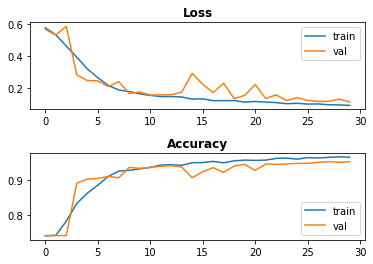



Confusion Matrix, without normalization


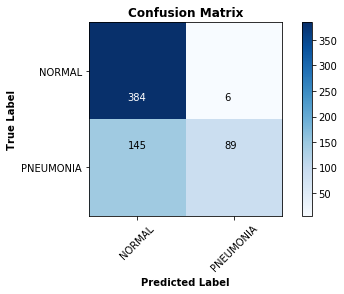



              precision    recall  f1-score   support

      NORMAL       0.73      0.98      0.84       390
   PNEUMONIA       0.94      0.38      0.54       234

    accuracy                           0.76       624
   macro avg       0.83      0.68      0.69       624
weighted avg       0.81      0.76      0.73       624



In [70]:
print(mf.evaluate_test(model_downsample_128, history_downsample_128, class_labels, train_images_128, test_images_128, train_y_128, test_y_128))

### 256x256 <a id='256'></a>

In [125]:
train_generator_256 = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(256, 256), color_mode = 'grayscale', batch_size = 4188)
test_generator_256 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(256, 256), color_mode = 'grayscale', batch_size = 624)
val_generator_256 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(256, 256), color_mode = 'grayscale', batch_size = 1048)

Found 4186 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1046 images belonging to 2 classes.


In [126]:
train_images_256, train_labels_256 = next(train_generator_256)
test_images_256, test_labels_256 = next(test_generator_256)
val_images_256, val_labels_256 = next(val_generator_256)
train_y_256 = np.reshape(train_labels_256[:,1], (4186,1))
test_y_256 = np.reshape(test_labels_256[:,1], (624,1))
val_y_256 = np.reshape(val_labels_256[:,1], (1046,1))
print ("train_images shape: " + str(train_images_256.shape))
print ("train_labels shape: " + str(train_labels_256.shape))
print ("test_images shape: " + str(test_images_256.shape))
print ("test_labels shape: " + str(test_labels_256.shape))
print ("val_images shape: " + str(val_images_256.shape))
print ("val_labels shape: " + str(val_labels_256.shape))

train_images shape: (4186, 256, 256, 1)
train_labels shape: (4186, 2)
test_images shape: (624, 256, 256, 1)
test_labels shape: (624, 2)
val_images shape: (1046, 256, 256, 1)
val_labels shape: (1046, 2)


In [127]:
model_downsample_256 = models.Sequential()
model_downsample_256.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model_downsample_256.add(layers.MaxPooling2D((2, 2)))

model_downsample_256.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_downsample_256.add(layers.MaxPooling2D((2, 2)))

model_downsample_256.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_downsample_256.add(layers.MaxPooling2D((2, 2)))

model_downsample_256.add(layers.Flatten())
model_downsample_256.add(layers.Dense(64, activation='relu'))
model_downsample_256.add(layers.Dense(1, activation='sigmoid'))

model_downsample_256.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [128]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_downsample_256 = model_downsample_256.fit(train_images_256,
                    train_y_256,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_256, val_y_256),
                                                 callbacks=early_stopping)

Train on 4186 samples, validate on 1046 samples
Epoch 1/200
4186/4186 [==============================] - 11s 3ms/step - loss: 0.5488 - acc: 0.7446 - val_loss: 0.4707 - val_acc: 0.7486
Epoch 2/200
4186/4186 [==============================] - 10s 3ms/step - loss: 0.4556 - acc: 0.8120 - val_loss: 0.4494 - val_acc: 0.8174
Epoch 3/200
4186/4186 [==============================] - 11s 3ms/step - loss: 0.3181 - acc: 0.8767 - val_loss: 0.2460 - val_acc: 0.9063
Epoch 4/200
4186/4186 [==============================] - 11s 3ms/step - loss: 0.2219 - acc: 0.9173 - val_loss: 0.1812 - val_acc: 0.9321
Epoch 5/200
4186/4186 [==============================] - 11s 3ms/step - loss: 0.1812 - acc: 0.9288 - val_loss: 0.2090 - val_acc: 0.9226
Epoch 6/200
4186/4186 [==============================] - 11s 3ms/step - loss: 0.1550 - acc: 0.9446 - val_loss: 0.1868 - val_acc: 0.9273
Epoch 7/200
4186/4186 [==============================] - 10s 3ms/step - loss: 0.1416 - acc: 0.9486 - val_loss: 0.1752 - val_acc: 0.9359


Accuracy 
 Train: 0.973, Test: 0.715
Loss 
 Train: 0.067, Test: 1.272 



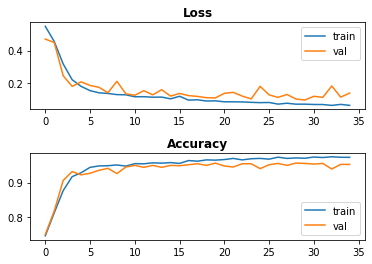



Confusion Matrix, without normalization


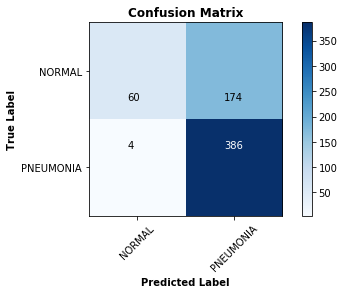



              precision    recall  f1-score   support

      NORMAL       0.94      0.26      0.40       234
   PNEUMONIA       0.69      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.81      0.62      0.61       624
weighted avg       0.78      0.71      0.66       624



In [129]:
print(mf.evaluate_test(model_downsample_256, history_downsample_256, class_labels, train_images_256, test_images_256, train_y_256, test_y_256))

Using a smaller image size led to a very low recall score, so we will try to use a larger image size whenever possible.